In [3]:
%matplotlib inline

In [4]:
import kplr
import pystan
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INFO:root:Found local file: '/Users/dfm/.kplr/data/lightcurves/006762829/kplr006762829-2010174085026_llc.fits'


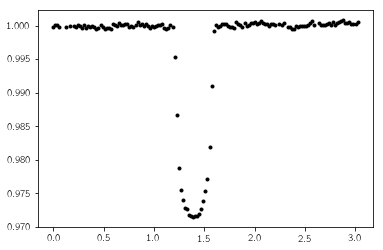

In [5]:
client = kplr.API()
kicid = 6762829
star = client.star(kicid)

lcs = star.get_light_curves(short_cadence=False)
data = lcs[4].read()
t = np.array(data["TIME"], dtype=float)
y = np.array(data["PDCSAP_FLUX"], dtype=float)
yerr = np.array(data["PDCSAP_FLUX_ERR"], dtype=float)
q = np.array(data["SAP_QUALITY"])

m = (650 < np.arange(len(t))) & (np.arange(len(t)) < 800)
m &= np.isfinite(t) & np.isfinite(y) & np.isfinite(yerr) & (q == 0)

t = t[m] - t[m].min()
mu = np.median(y[m])
y = y[m] / mu
yerr = yerr[m] / mu

texp = np.median(np.diff(t))

plt.plot(t, y, ".k");

In [6]:
code = """
functions {
    real limb_darkening(real q1, real q2, real p, real z);
}
data {
    int<lower=0> N;          // number of times
    real t[N];               // the times
    real y[N];               // the fluxes
    real<lower=0> sigma[N];  // the flux uncertainties
    real texp;
    int<lower=0> Npred;
    real tpred[Npred];
}
parameters {
    real<lower=0, upper=1> q1;
    real<lower=0, upper=1> q2;
    real<lower=1, upper=2> t0;
    real<lower=log(0.01), upper=log(1.0)> logror;
    real<lower=log(0.1), upper=log(1.5)> logtau;
    real<lower=0, upper=1> b;
}
transformed parameters {
    real ror;
    real factor;
    ror = exp(logror);
    factor = 2 * sqrt((1+exp(logror))^2 - b^2) / exp(logtau);
}
model {
    for (n in 1:N) {
        real mod = 0;
        for (j in 1:3) {
            mod = mod + limb_darkening(q1, q2, ror, sqrt(b^2 + (factor * (t[n] + (j - 2) * texp / 3 - t0))^2));
        }
        y[n] ~ normal(mod / 3, sigma[n]);
    }    
}
generated quantities {
    real pred[Npred];
    for (n in 1:Npred) {
        pred[n] = 0;
        for (j in 1:3) {
            pred[n] = pred[n] + limb_darkening(q1, q2, ror, sqrt(b^2 + (factor * (tpred[n] + (j - 2) * texp / 3))^2));
        }
        pred[n] = pred[n] / 3;
    }
}
"""

In [8]:
model = pystan.StanModel(model_code=code, allow_undefined=True,
                         includes=["include/ellint.hpp", "include/limb_darkening.hpp"])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea6b64c0ecefd0af2c146db3c0c01de3 NOW.


In [9]:
tpred = np.linspace(-1.5, 1.5, 500)
data = dict(N=len(t), t=t, y=y, sigma=yerr, texp=texp, Npred=len(tpred), tpred=tpred)

In [10]:
fit = model.sampling(iter=1000, data=data)

In [13]:
results = fit.extract(permuted=True)

In [15]:
samples = np.array([results["q1"], results["q2"], results["t0"], results["b"], results["ror"]]).T

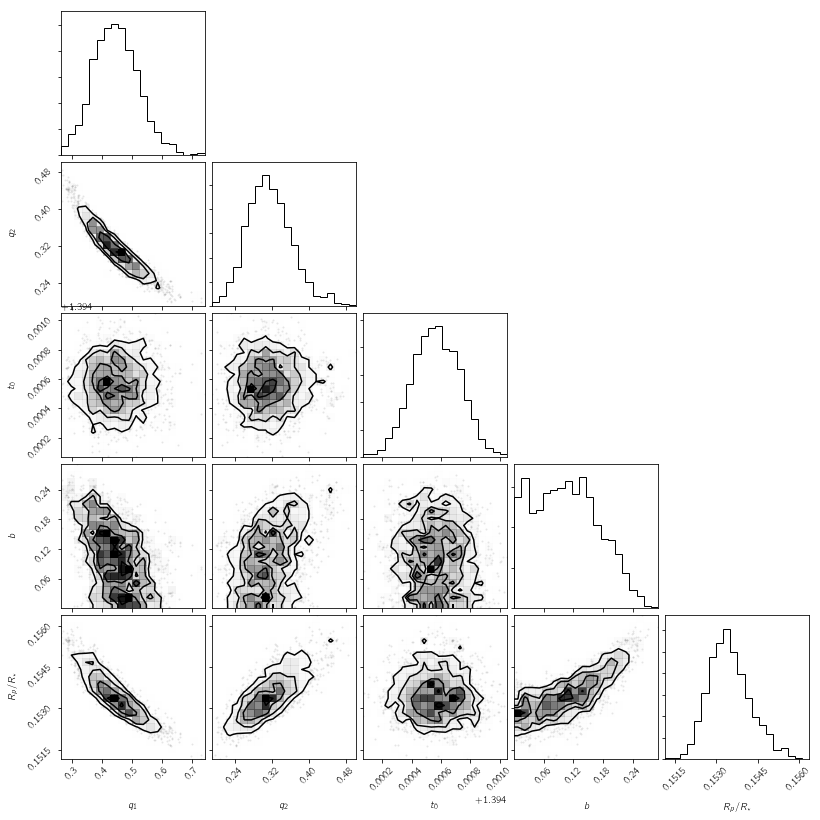

In [17]:
corner.corner(samples, labels=["$q_1$", "$q_2$", "$t_0$", "$b$", "$R_p/R_\star$"]);

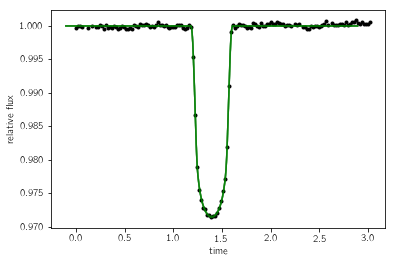

In [21]:
plt.plot(t, y, ".k")

for i in np.random.randint(len(samples), size=25):
    t0 = results["t0"][i]
    pred = results["pred"][i]
    plt.plot(tpred + t0, pred, "g", alpha=0.1)

plt.xlabel("time")
plt.ylabel("relative flux");